In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy as sp
from tqdm import tqdm
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from helpers import (Fy, find_closest_element,  compute_coverage, #predict_single_density,
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)
from density_predictor_class_val import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/B_zeta_val.npy')
beta = np.genfromtxt('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/beta.csv', delimiter = ',')
#B_zeta = B_zeta.reshape(B_zeta.shape[0], B_zeta.shape[])
true_y = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/labels_val.npy')
true_z = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/tr_labels_val.npy')

B_zeta = B_zeta[np.abs(true_y) < 50,:] 
true_z = true_z[np.abs(true_y) < 50]
true_y = true_y[np.abs(true_y) < 50]

density_path = '../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 500

In [ ]:
plt.scatter(true_z, B_zeta.dot(beta), alpha = 0.2)

(-20.0, 20.0)

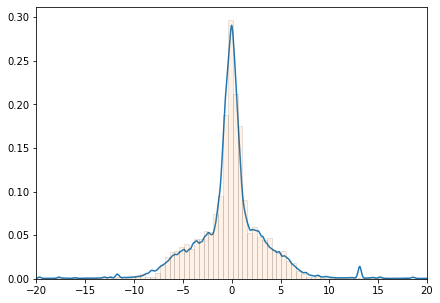

In [3]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.plot(density['axes'], density['pdf'])
ax.hist(true_y, bins=200, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.set_xlim(-20,20)

In [8]:
dens = density_predictor(B_zeta, true_y, density, no_points)

In [5]:
result_va_ridge = dens.get_density('va_ridge')
result_hmc_ridge = dens.get_density('hmc_ridge')

  0%|          | 72/94805 [00:00<02:11, 719.24it/s]

computing densities for each observation


  1%|          | 947/94805 [00:00<00:09, 9450.70it/s]

computing mean prediction for each observation


  2%|▏         | 1689/94805 [00:00<00:05, 16884.70it/s]

computing variance prediction for each observation


100%|██████████| 94805/94805 [00:05<00:00, 16869.78it/s]


In [7]:
from helpers import (Fy, find_closest_element,  compute_coverage, #predict_single_density,
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import trapz

class density_predictor():
    
    def __init__(self, B_zeta, true_y, density, no_points):
        # initialize
        self.B_zeta = B_zeta
        self.true_y = true_y
        self.density = density
        self.no_points = no_points
        self.p = self.B_zeta.shape[1]
        
        # compute fixed terms and grid
        self.p_y_y0,  self.part_1, self.phi_1_z, self.grid = generate_fixed_terms(self.no_points, self.density)
        
    def generate_fixed_terms(self):
    
        self.grid = np.linspace(min(self.density['axes']), max(self.density['axes']), self.no_points)
        self.density_y = self.density['axes']
        self.density_pdf = self.density['pdf']
        # compute these beforehand to save computation time
        self.p_y_y0 = [self.density_pdf[find_closest_element(y_i,density_y)] for y_i in self.grid]
        self.part_1 = np.array([norm.ppf(Fy(y_i, self.density)) for y_i in self.grid])
        self.phi_1_z = np.array([norm(0, 1).pdf(y_i) for y_i in self.part_1 ])
        
        return(self.p_y_y0,  self.part_1, self.phi_1_z, self.grid)
    
    def predict_single_density(self, x, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method):
    
    
        self.psi_x0 = x
        if self.method == 'dnn_c':
            self.f_eta_x0 = self.psi_x0.dot(self.beta[0:p]) + self.beta[p]
        else:
            self.f_eta_x0 = self.psi_x0.dot(self.beta)

        if self.method == 'va_ridge':
            self.s_0_hat = (1 + self.tau_sq*self.psi_x0.dot(self.psi_x0))**(-0.5)

        elif self.method == 'hmc_ridge':
            self.s_0_hats =  []
            for tau_j in self.tau_sq:
                self.s_0_hatj = (1 + tau_j*self.psi_x0.dot(self.psi_x0))**(-0.5)
                self.s_0_hats.append(self.s_0_hatj)
            self.s_0_hat = np.mean(np.array(self.s_0_hats))

        elif self.method == 'va_horseshoe':
            self.s_0_hat = (1 + (self.psi_x0*(self.Lambda**2)).dot(self.psi_x0))**(-0.5)

        elif self.method == 'hmc_horseshoe':
            self.s_0_hats =  []
            for Lambda_j in self.Lambda:
                self.s_0_hatj = (1 + (self.psi_x0*(Lambda_j**2)).dot(self.psi_x0))**(-0.5)
                self.s_0_hats.append(self.s_0_hatj)
            self.s_0_hat = np.mean(np.array(self.s_0_hats))
            
        if self.method == 'dnn_c':
            self.s_0_hat = (1 + self.psi_x0.dot(self.psi_x0))**(-0.5)

        self.part_0 = self.s_0_hat*self.f_eta_x0

        # compute the cdf of new ys
        self.term_1 = norm(0, 1).pdf((self.part_1- self.part_0) / self.s_0_hat)
        self.p_y_single_obs_whole_dens = (self.p_y_y0/self.phi_1_z)*(1/self.s_0_hat)*self.term_1

        return(self.p_y_single_obs_whole_dens)
    
    def get_density(self, method):
        
        self.method = method
        
        if self.method == 'va_ridge':
            
            self.va_ridge_dir = '../../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/'
            self.mu_t_va = np.load('../../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/mu_ts23_factor_50.npy')
            self.iterations = self.mu_t_va.shape[0]
            self.beta = np.mean(self.mu_t_va[int(0.9*self.iterations):self.iterations,0:10], axis = 0)
            self.beta_sd = np.std(self.mu_t_va[int(0.9*self.iterations):self.iterations,0:10], axis = 0)
            self.tau_sq = np.mean(np.exp(self.mu_t_va[int(0.9*self.iterations):self.iterations,10]), axis = 0)
            self.tau_sq_sd = np.std(np.exp(self.mu_t_va[int(0.9*self.iterations):self.iterations,10]), axis = 0)
            
            print('computing densities for each observation')
            self.densities_va = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.dens = self.predict_single_density(self.B_zeta[i].reshape(self.p,), self.grid, self.p_y_y0, 
                                                   self.part_1, self.phi_1_z, self.beta, self.tau_sq, None, 
                                                   self.method)
                self.densities_va.append(self.dens)
            
            print('computing mean prediction for each observation')
            # mean prediction
            self.pred_y_va_ridge = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*self.grid, self.grid)
                self.pred_y_va_ridge.append(self.y_i)
            self.pred_y_va_ridge = np.array(self.pred_y_va_ridge)
            
            print('computing variance prediction for each observation')
            # variance prediction
            self.pred_y_va_ridge_var = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*((self.grid - self.pred_y_va_ridge[i])**2), self.grid)
                self.pred_y_va_ridge_var.append(self.y_i)
            
            self.pred_y_va_ridge_var = np.array(self.pred_y_va_ridge_var)
            
            return({'densities': self.densities_va, 
                    'mean predictions': self.pred_y_va_ridge, 
                    'variance preditcion': self.pred_y_va_ridge_var})
        
        if self.method == 'va_horseshoe':
        
            self.va_horse_dir = '../../../data/commaai/va/unfiltered_gaussian_resampled/Horseshoe/'
            self.mu_t_va = np.load(self.va_horse_dir + 'mu_ts2_new_dev_1.npy').reshape(-1, 21)
            self.iter = self.mu_t_va.shape[0]
            self.beta = np.mean(self.mu_t_va[int(0.9*self.iter):,0:10], axis = 0)
            self.Lambda = np.mean(np.exp(0.5*self.mu_t_va[int(0.9*self.iter):,10:20]), axis = 0)
            self.tau_sq = np.exp(np.mean(self.mu_t_va[int(0.9*self.iter):,20], axis = 0))
            self.z_pred = self.B_zeta.reshape(self.B_zeta.shape[0], self.p).dot(self.beta)
            self.pred_y = [self.density.loc[find_closest_element(norm.cdf(z), self.density['cdf']), 'axes'] for z in self.z_pred]
            
            self.densities_va = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.dens = self.predict_single_density(self.B_zeta[i].reshape(self.p,), self.grid, self.p_y_y0, 
                                                   self.part_1, self.phi_1_z, self.beta, self.tau_sq, self.Lambda, 
                                                   'va_horseshoe')
                self.densities_va.append(self.dens)
               
            self.pred_y_va_horse = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*self.grid, self.grid)
                self.pred_y_va_horse.append(self.y_i)
                
            # variance prediction
            self.pred_y_va_horse_var = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*((self.grid - self.pred_y_va_horse[i])**2), self.grid)
                self.pred_y_va_horse_var.append(self.y_i)
                
            return({'densities': self.densities_va, 
                    'mean prediction': self.pred_y_va_horse, 
                    'variance prediction': self.pred_y_va_horse_var})
        
        if self.method == 'hmc_ridge':
            
            self.hmc_ridge_dir = '../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Ridge/'
            self.mu_t_hmc = np.load(self.hmc_ridge_dir + 'all_thetas_L100_5000.npy')[500:,:]
            self.beta = np.mean(self.mu_t_hmc[:,0:10], axis = 0)
            self.tau_sq = np.exp(self.mu_t_hmc[:,10])
            self.z_pred = self.B_zeta.reshape(self.B_zeta.shape[0], self.p).dot(self.beta)
            self.pred_y = [self.density.loc[find_closest_element(norm.cdf(z), self.density['cdf']), 'axes'] for z in self.z_pred]
            
            self.densities_va = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.dens = self.predict_single_density(self.B_zeta[i].reshape(self.p,), self.grid, self.p_y_y0, 
                                              self.part_1, self.phi_1_z, self.beta, self.tau_sq, None, 'hmc_ridge')
                self.densities_va.append(self.dens)

            self.pred_y_hmc_ridge = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*self.grid, self.grid)
                self.pred_y_hmc_ridge.append(self.y_i)

            # variance prediction
            self.pred_y_hmc_ridge_var = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*((self.grid - self.pred_y_hmc_ridge[i])**2), self.grid)
                self.pred_y_hmc_ridge_var.append(self.y_i)

            return({'densities': self.densities_va, 
                    'mean prediction': np.array(self.pred_y_hmc_ridge), 
                    'variance prediction': np.array(self.pred_y_hmc_ridge_var)})

        if self.method == 'hmc_horseshoe':
            self.hmc_ridge_dir = '../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/'
            self.mu_t_hmc = np.load(self.hmc_ridge_dir + 'all_thetas_try.npy').reshape(-1, 21)
            self.beta = np.mean(self.mu_t_hmc[2000:,0:10], axis = 0)
            self.Lambda = np.exp(0.5*self.mu_t_hmc[2000:,10:20])
            self.tau_sq = np.exp(self.mu_t_hmc[2000:,20])
            self.z_pred = self.B_zeta.reshape(self.B_zeta.shape[0], self.p).dot(self.beta)
            self.pred_y = [self.density.loc[find_closest_element(norm.cdf(z), self.density['cdf']), 'axes'] for z in self.z_pred]
            
            self.densities_va = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.dens = self.predict_single_density(self.B_zeta[i].reshape(self.p,), self.grid, self.p_y_y0, 
                                              self.part_1, self.phi_1_z, self.beta, self.tau_sq, None, 'hmc_horseshoe')
                self.densities_va.append(self.dens)

            self.pred_y_hmc_ridge = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*self.grid, self.grid)
                self.pred_y_hmc_ridge.append(self.y_i)

            # variance prediction
            self.pred_y_hmc_ridge_var = []
            for i in tqdm(range(0, self.B_zeta.shape[0])):
                self.y_i = trapz(self.densities_va[i]*((self.grid - self.pred_y_hmc_ridge[i])**2), self.grid)
                self.pred_y_hmc_ridge_var.append(self.y_i)
       
            return({'densities': self.densities_va, 
                    'mean prediction': np.array(self.pred_y_hmc_ridge), 
                    'variance prediction': np.array(self.pred_y_hmc_ridge_var)})

In [9]:
result_va_horse = dens.get_density('va_horseshoe')
result_hmc_horse = dens.get_density('hmc_horseshoe')

100%|██████████| 94805/94805 [00:05<00:00, 16482.21it/s]


In [10]:
z_pred = B_zeta.dot(beta) 
y_pred = np.array([density.loc[find_closest_element(norm.cdf(i), density['cdf']), 'axes'] for i in tqdm(z_pred)])

100%|██████████| 94805/94805 [00:30<00:00, 3159.21it/s]


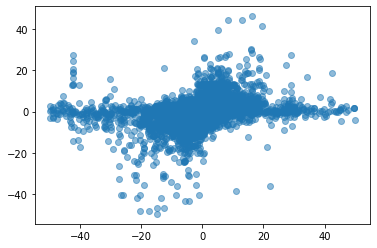

In [12]:
plt.scatter(true_y, y_pred , alpha = 0.5)

In [13]:
print('Validation Performance: ' +
      '\nMSE:' +
     '\n CIL VA/Ridge: ' + str(np.mean((true_y - np.array(result_va_ridge['mean predictions']))**2)) +
     '\n CIL HMC/Ridge: ' + str(np.mean((true_y - np.array(result_hmc_ridge['mean prediction']))**2)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean((true_y - np.array(result_va_horse['mean prediction']))**2)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean((true_y - np.array(result_hmc_horse['mean prediction']))**2)) +
     '\n CIL No Bayes: ' + str(np.mean((true_y - y_pred)**2)) +
     '\n CIL Benchmark: ' + str(np.mean((true_y - 0)**2)) +
      
    '\nMAE:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])))) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])))) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])))) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])))) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred))) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0))) +
      
      '\nAccuracy:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])) < 6)) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])) < 6)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])) < 6)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])) < 6)) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred) < 6)) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0) < 6))
     )

Validation Performance: 
MSE:
 CIL VA/Ridge: 14.208108966023076
 CIL HMC/Ridge: 14.193295509434003
 CIL VA/Horseshoe: 14.300611924092017
 CIL HMC/Horseshoe: 14.17757815701489
 CIL No Bayes: 13.050320078795423
 CIL Benchmark: 16.62251706133643
MAE:
 CIL VA/Ridge: 2.325465495536326
 CIL HMC/Ridge: 2.3248970764435963
 CIL VA/Horseshoe: 2.339929118083068
 CIL HMC/Horseshoe: 2.324946093967559
 CIL No Bayes: 1.9274159357560738
 CIL Benchmark: 2.3982901745688525
Accuracy:
 CIL VA/Ridge: 0.9458467380412425
 CIL HMC/Ridge: 0.9460155055113127
 CIL VA/Horseshoe: 0.9464901640208849
 CIL HMC/Horseshoe: 0.9475344127419439
 CIL No Bayes: 0.9530720953536206
 CIL Benchmark: 0.9155740730974105


In [14]:
df = pd.DataFrame({'va_ridge' : result_va_ridge['densities'],
                 'hmc_ridge' : result_hmc_ridge['densities'],
                 'va_horse' : result_va_horse['densities'],
                 'hmc_horse' : result_hmc_horse['densities']})

In [ ]:
df.to_csv('../../../data/commaai/predictions/cil/densities.csv')